Este código toma como entrada todas las features y labels, arma secuencias para meter en el dataset seq to vec, y tira todas las seq que tengan menos de un 80% de una misma clase.



In [1]:
import numpy as np
import pickle
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import math
import statistics as stat

In [4]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_2/datos_crudos2feature_dataset"

/content/drive/.shortcut-targets-by-id/1p7dFFKqLvO4o4GAmIQpnbXVWvt_2Dv-l/repo_tesis/src/ronda_experimentos_2/datos_crudos2feature_dataset


In [5]:
FEATURES = joblib.load('features_full_W200_I50.pkl')

In [6]:
labels_df = joblib.load("label_full_W200_I50.pkl")

In [7]:
sample_weight = joblib.load("sample_weight_selected.pkl")

# Separación de datos por sujeto

In [7]:
nOfSubjects = 10

# id_ventana = labels_df['id_ventana'].values
features_array = FEATURES.values
id_gesto = labels_df['id_gesto'].values
subject = labels_df['subject'].values

# hago una lista de Dataframes
list_features_x_sujeto = []
list_label_x_sujeto = []
list_sample_weight_x_sujeto = []

for i in range(1, nOfSubjects+1):  # luego podría no hardcodearlo

  ind_sujeto_act = np.where(subject==i)[0]
  list_features_x_sujeto.append(features_array[ind_sujeto_act])
  list_label_x_sujeto.append(id_gesto[ind_sujeto_act])
  # list_sample_weight_x_sujeto.append(sample_weight[ind_sujeto_act])

# Para un sujeto en particular


## Selección de secuencias


In [ ]:
j = 0
label_j = list_label_x_sujeto[j]
data_j = list_features_x_sujeto[j]
input_sequence_length = 80 # Cada gesto dura 5s aprox, y el incremento es de 50ms

label_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
        targets=None,
        sequence_length=input_sequence_length,
        batch_size=None,   # multiplo de 8
        sequence_stride = 1
      )
data_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
        targets=None,
        sequence_length=input_sequence_length,
        batch_size=None,   # multiplo de 8
        sequence_stride = 1
      )


In [ ]:
secuencias_labels_list = []
secuencias_features_list = []

for x in label_dataset:
  secuencias_labels_list.append(x)

for x in data_dataset:
  secuencias_features_list.append(x)

In [ ]:
selected_secuencias_labels_list = []
selected_secuencias_features_list = []

contador = 0

for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
  unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
  # Encontrar el valor que más se repite
  max_count_index = np.argmax(counts)
  most_frequent_value = unique_values[max_count_index]
  counts_most_frequent = counts[max_count_index]

  if ((counts_most_frequent/len(secuencias_labels_list[i])) > 0.85):
    if most_frequent_value == 0:
      if contador<150:
        selected_secuencias_labels_list.append(most_frequent_value)
        selected_secuencias_features_list.append(secuencias_features_list[i])
      contador += 1
    else:
      selected_secuencias_labels_list.append(most_frequent_value)
      selected_secuencias_features_list.append(secuencias_features_list[i])

(array([100.,  93.,  84.,  79.,  85.,  97.,  97.,  96.,  98.,  81.,  89.,
         96.,  80.]),
 array([ 0.        ,  0.92307692,  1.84615385,  2.76923077,  3.69230769,
         4.61538462,  5.53846154,  6.46153846,  7.38461538,  8.30769231,
         9.23076923, 10.15384615, 11.07692308, 12.        ]),
 <BarContainer object of 13 artists>)

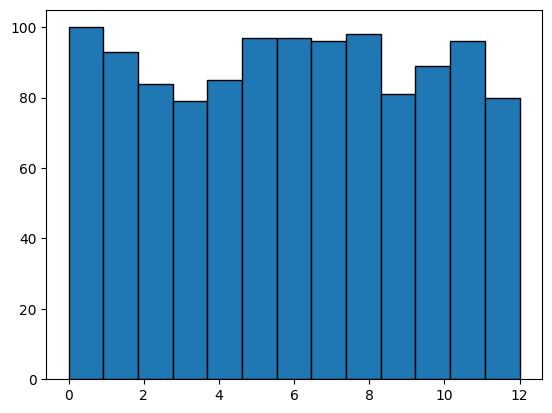

In [ ]:
# Crear el histograma
plt.hist(np.array(selected_secuencias_labels_list), bins=13, edgecolor='black')

Tengo que calcular el vector de pesos asociado

## Manejo de desbalance de datos

In [9]:
selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)

# Calcula los pesos de clase
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(selected_secuencias_labels_array), y=selected_secuencias_labels_array)

NameError: name 'selected_secuencias_labels_list' is not defined

In [ ]:
class_weights

In [ ]:
# Convierte los pesos a un diccionario
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Pesos de clase:", class_weights_dict)

# Crear una matriz de pesos de la misma forma que y_train
sample_weight = np.zeros(selected_secuencias_labels_array.shape)

# Asignar los pesos de clase a cada timestep en la secuencia
for i, class_weight in class_weights_dict.items():
    sample_weight[selected_secuencias_labels_array == i] = class_weight

# Verificar la forma de sample_weight
print("Sample weight shape:", sample_weight.shape)
print("y_train shape:", selected_secuencias_labels_array.shape)

Pesos de clase: {0: 0.11551633298208641, 1: 2.6984615384615385, 2: 2.8108974358974357, 3: 2.8775063798760483, 4: 2.7979439914923785, 5: 2.651326839099765, 6: 2.651326839099765, 7: 2.6629554655870447, 8: 2.639799331103679, 9: 2.850487540628386, 10: 2.747302471284372, 11: 2.6629554655870447, 12: 3.1955465587044536}
Sample weight shape: (7893,)
y_train shape: (7893,)


In [ ]:
# joblib.dump(selected_secuencias_labels_array, "sample_weight_selected.pkl")

['sample_weight_selected.pkl']

# Armo el dataset para cada sujeto

In [10]:
sample_weight_j = tf.convert_to_tensor(sample_weight, dtype=tf.float32)
sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)

In [ ]:
# sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)

# Convertir las listas en tensores de TensorFlow
tensores = tf.stack(selected_secuencias_features_list)
etiquetas = tf.convert_to_tensor(selected_secuencias_labels_list)

# Crear un dataset a partir de los tensores y etiquetas
input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))

In [ ]:
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

NameError: name 'rnn_dataset_j' is not defined

In [ ]:
for x, y, z in rnn_dataset_j_def.take(1):
  print(x.shape)
  print(y)
  print(z)

(50, 240)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0.115516335, shape=(), dtype=float32)


# Para todos los sujetos

## Con reposo, sin pesos

In [13]:
for j in range(nOfSubjects):#
  label_j = list_label_x_sujeto[j]
  data_j = list_features_x_sujeto[j]
  input_sequence_length = 61 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 1
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 1
        )

  secuencias_labels_list = []
  secuencias_features_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_features_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_features_list = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]


    if (((counts_most_frequent/len(secuencias_labels_list[i])) > 0.85)): #
      if (most_frequent_value==0):
        if (contador_reposos<250):
          contador_reposos += 1
          selected_secuencias_labels_list.append(secuencias_labels_list[i]) # most_frequent_value
          selected_secuencias_features_list.append(secuencias_features_list[i])
      else:
        selected_secuencias_labels_list.append(secuencias_labels_list[i]) # most_frequent_value
        selected_secuencias_features_list.append(secuencias_features_list[i])

  # # Visualizar cantidad de cada clase
  # plt.figure()
  # plt.hist(np.array(selected_secuencias_labels_list), bins=13, edgecolor='black')
  # plt.title('Cantidad de cada clase para el sujeto'+str(j))

  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(selected_secuencias_features_list)
  etiquetas = tf.convert_to_tensor(list(selected_secuencias_labels_array))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  # Guardar el dataset
  input_dataset.save("2025_dataset_E1_con_reposo_features_sub"+str(j))

## Con reposo

Pesos de clase: {0: 0.7530769230769231, 1: 1.004102564102564, 2: 1.045940170940171, 3: 1.070725483047758, 4: 1.0411201701524282, 5: 0.9865636546859254, 6: 0.9865636546859254, 7: 0.9908906882591093, 8: 0.9822742474916388, 9: 1.0606717226435536, 10: 1.022276366167769, 11: 0.9908906882591093, 12: 1.1890688259109312}
Sample weight shape: (2937,)
y_train shape: (2937,)
Pesos de clase: {0: 0.9907692307692307, 1: 1.0847838293093768, 2: 1.0502854036422942, 3: 1.0144394854292464, 4: 1.0007770007770007, 5: 0.9681784014031571, 6: 0.9557259460796438, 7: 0.9681784014031571, 8: 0.965034965034965, 9: 1.017913593256059, 10: 0.8640429338103757, 11: 0.9777327935222672, 12: 1.2181588902900378}
Sample weight shape: (3864,)
y_train shape: (3864,)
Pesos de clase: {0: 0.7538461538461538, 1: 1.014142807864781, 2: 1.0421836228287842, 3: 1.0617551462621886, 4: 1.0518783542039356, 5: 0.9832775919732442, 6: 0.9919028340080972, 7: 0.987571380584481, 8: 0.987571380584481, 9: 1.0617551462621886, 10: 1.02332057083188

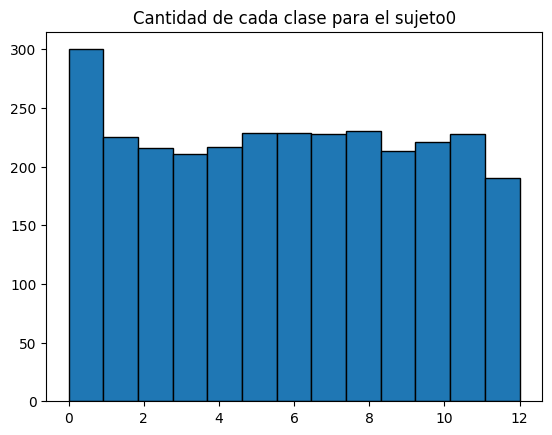

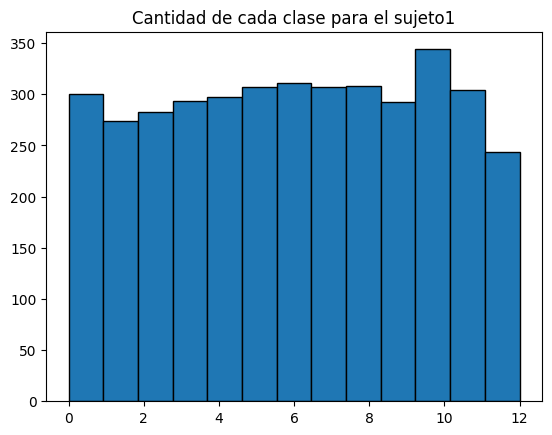

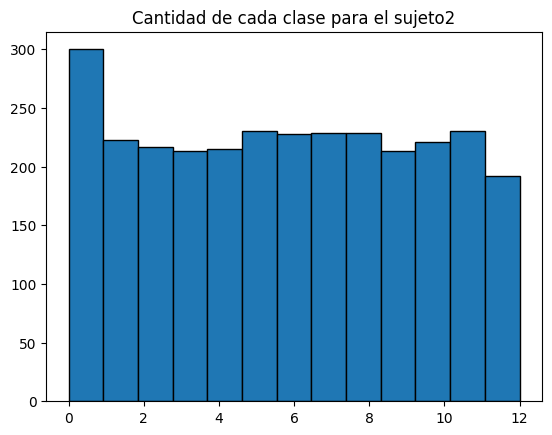

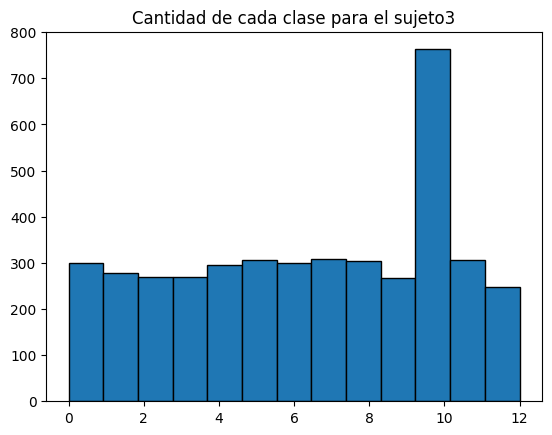

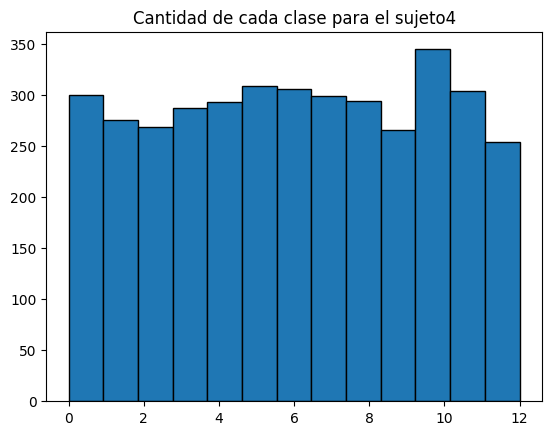

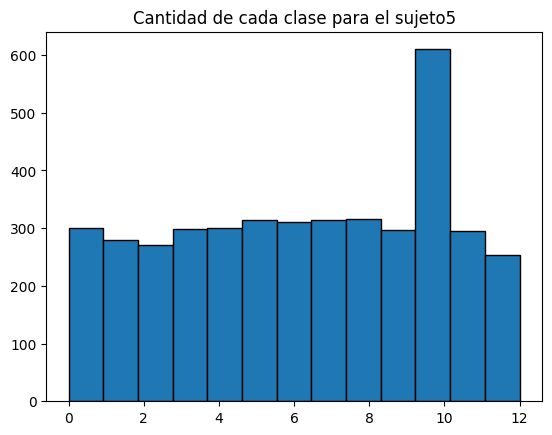

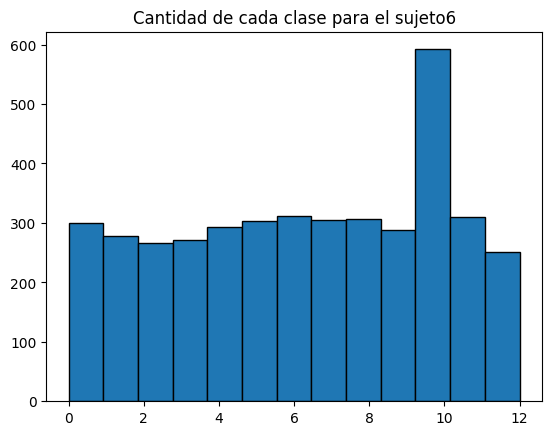

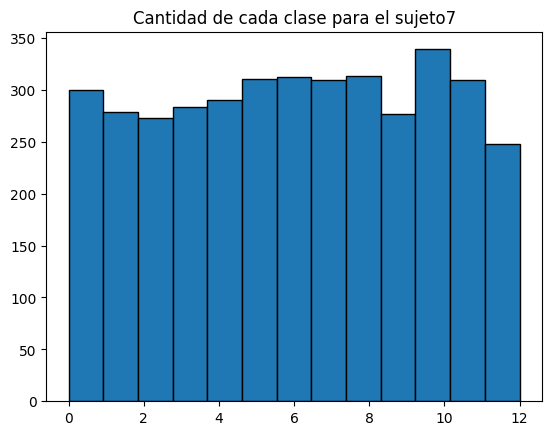

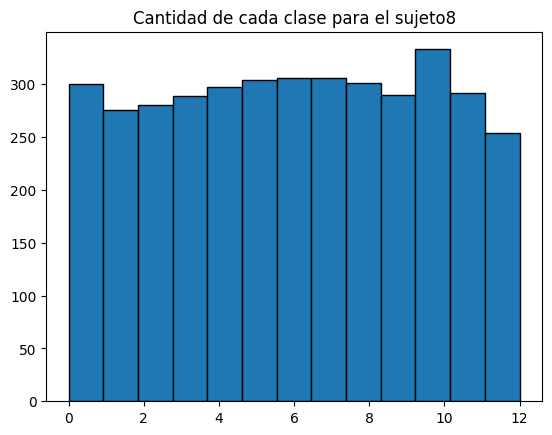

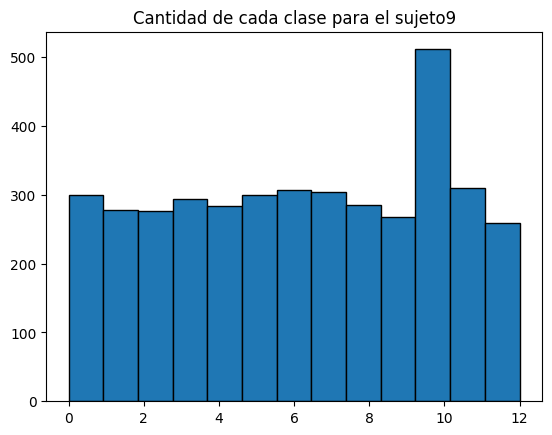

In [ ]:
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

for j in range(0, nOfSubjects):
  label_j = list_label_x_sujeto[j]
  data_j = list_features_x_sujeto[j]
  input_sequence_length = 61 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 1
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 1
        )

  secuencias_labels_list = []
  secuencias_features_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_features_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_features_list = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]


    if (((counts_most_frequent/len(secuencias_labels_list[i])) > 0.85)): #
      if (most_frequent_value==0):
        if (contador_reposos<300):
          contador_reposos += 1
          selected_secuencias_labels_list.append(most_frequent_value)
          selected_secuencias_features_list.append(secuencias_features_list[i])
      else:
        selected_secuencias_labels_list.append(most_frequent_value)
        selected_secuencias_features_list.append(secuencias_features_list[i])

  # Visualizar cantidad de cada clase
  plt.figure()
  plt.hist(np.array(selected_secuencias_labels_list), bins=13, edgecolor='black')
  plt.title('Cantidad de cada clase para el sujeto'+str(j))

  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)

  # Calcula los pesos de clase
  class_weights = compute_class_weight(class_weight='balanced',
                                      classes=np.unique(selected_secuencias_labels_array), y=selected_secuencias_labels_array)
  # Convierte los pesos a un diccionario
  class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

  print("Pesos de clase:", class_weights_dict)

  # Crear una matriz de pesos de la misma forma que y_train
  sample_weight = np.zeros(selected_secuencias_labels_array.shape)

  # Asignar los pesos de clase a cada timestep en la secuencia
  for i, class_weight in class_weights_dict.items():
      sample_weight[selected_secuencias_labels_array == i] = class_weight

  # Verificar la forma de sample_weight
  print("Sample weight shape:", sample_weight.shape)
  print("y_train shape:", selected_secuencias_labels_array.shape)

  # Armo los datasets
  sample_weight_j = tf.convert_to_tensor(sample_weight, dtype=tf.float32)
  sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)
  # sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(selected_secuencias_features_list)
  etiquetas = tf.convert_to_tensor(selected_secuencias_labels_list)

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))

  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  rnn_dataset_j_def.save("2025_dataset_E1_selected_sub"+str(j))

In [8]:
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

for j in range(0, nOfSubjects):
  label_j = list_label_x_sujeto[j]
  data_j = list_features_x_sujeto[j]
  input_sequence_length = 61 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 1
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 1
        )

  secuencias_labels_list = []
  secuencias_features_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_features_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_features_list = []

  contador = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if ((counts_most_frequent/len(secuencias_labels_list[i])) == 1):
      if most_frequent_value == 0:
        if contador<150:
          selected_secuencias_labels_list.append(secuencias_labels_list[i])
          selected_secuencias_features_list.append(secuencias_features_list[i])
        contador += 1
      else:
        selected_secuencias_labels_list.append(secuencias_labels_list[i])
        selected_secuencias_features_list.append(secuencias_features_list[i])

  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)

  # # Calcula los pesos de clase
  # class_weights = compute_class_weight(class_weight='balanced',
  #                                     classes=np.unique(selected_secuencias_labels_array), y=selected_secuencias_labels_array)
  # # Convierte los pesos a un diccionario
  # class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

  # print("Pesos de clase:", class_weights_dict)

  # # Crear una matriz de pesos de la misma forma que y_train
  # sample_weight = np.zeros(selected_secuencias_labels_array.shape)

  # # Asignar los pesos de clase a cada timestep en la secuencia
  # for i, class_weight in class_weights_dict.items():
  #     sample_weight[selected_secuencias_labels_array == i] = class_weight

  # # Verificar la forma de sample_weight
  # print("Sample weight shape:", sample_weight.shape)
  # print("y_train shape:", selected_secuencias_labels_array.shape)

  # # Armo los datasets
  # sample_weight_j = tf.convert_to_tensor(sample_weight, dtype=tf.float32)
  # sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)
  # # sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(selected_secuencias_features_list)
  etiquetas = tf.convert_to_tensor(selected_secuencias_labels_list)

  # # Crear un dataset a partir de los tensores y etiquetas
  # input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  # rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))

  # rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas)) # borrar si se quieren usar pesos

  # rnn_dataset_j_def.save("2025_dataset_E1_sin_reposo_feature_sub"+str(j))

  input_dataset.save("2025_dataset_E1_sin_reposo_feature_sub"+str(j))

## Sin reposo

In [ ]:
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

# para cada sujeto armo un Dataset con las secuencias de datos y etiquetas

list_input_dataset_x_sujeto = []
list_labels_dataset_x_sujeto = []
list_sample_weight_dataset_x_sujeto = []
for j in range(nOfSubjects):
  data_j = list_features_x_sujeto[j]
  label_j = list_label_x_sujeto[j]
  sample_weight_j = list_sample_weight_x_sujeto[j]
  input_sequence_length = 100 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  input_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
        targets=label_j[input_sequence_length:],  # los objetivos empiezan desde input_sequence_length
        sequence_length=input_sequence_length,
        batch_size=None,   # multiplo de 8
        sequence_stride = 1
      )
  # list_input_dataset_x_sujeto.append(input_dataset)

  # sample_weight_dataset = tf.keras.utils.timeseries_dataset_from_array(
  #       data=sample_weight_j[input_sequence_length:],  # excluimos los últimos target_sequence_length elementos de los datos
  #       targets=None,  # los objetivos empiezan desde input_sequence_length
  #       sequence_length=1,
  #       batch_size=None,   # multiplo de 8
  #       sequence_stride = 1
  #     )
  # list_labels_dataset_x_sujeto.append(labels_dataset)

  # Alinear los pesos de muestra con las etiquetas
  adjusted_sample_weight_j = sample_weight_j[input_sequence_length:]

  # Convertir los pesos de muestra a tipo flotante y ajustar su forma
  adjusted_sample_weight_j = tf.convert_to_tensor(adjusted_sample_weight_j, dtype=tf.float32)
  sample_weight_dataset = tf.data.Dataset.from_tensor_slices(adjusted_sample_weight_j)


  rnn_dataset = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))


# rnn_dataset = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))
  rnn_dataset = rnn_dataset.map(combine_features_labels_weights)
  rnn_dataset.save("dataset_E1_sub"+str(j))


In [ ]:
list(rnn_dataset)

[(<tf.Tensor: shape=(100, 240), dtype=float64, numpy=
  array([[0.03953059, 0.6       , 0.34285714, ..., 0.01566815, 0.01009369,
          0.01731198],
         [0.01884257, 0.57142857, 0.22857143, ..., 0.00952425, 0.01018541,
          0.01723822],
         [0.01597522, 0.42857143, 0.2       , ..., 0.00861481, 0.00918638,
          0.01657462],
         ...,
         [0.00798761, 0.34285714, 0.        , ..., 0.01322369, 0.00761496,
          0.01064723],
         [0.00921648, 0.51428571, 0.        , ..., 0.01190579, 0.01019018,
          0.01076131],
         [0.0116742 , 0.62857143, 0.        , ..., 0.01432775, 0.00995793,
          0.01126884]])>,
  <tf.Tensor: shape=(), dtype=int64, numpy=0>,
  <tf.Tensor: shape=(100,), dtype=float64, numpy=
  array([0.13063713, 0.13063713, 0.13063713, 0.13063713, 0.13063713,
         0.13063713, 0.13063713, 0.13063713, 0.13063713, 0.13063713,
         0.13063713, 0.13063713, 0.13063713, 0.13063713, 0.13063713,
         0.13063713, 0.13063713, 0.13

In [ ]:
guardar_label = []
for x, y, z in rnn_dataset:
  guardar_label.append(y)

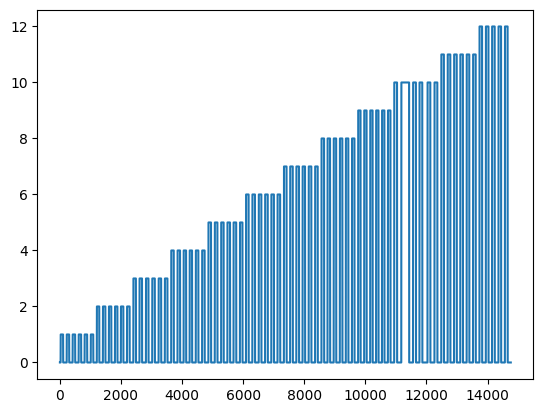

In [ ]:
plt.plot(guardar_label)

In [ ]:
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

# rnn_dataset = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))
rnn_dataset1 = rnn_dataset.map(combine_features_labels_weights)

for x, y, z in rnn_dataset1.take(1):
  input_shape = x[0].shape
  label_shape = x[1].shape
  sample_weight_shape = z.shape
print('Input shape:', input_shape)
print('Label shape:', label_shape)
print('Sample weight shape:', sample_weight_shape)

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__combine_features_labels_weights() takes 2 positional arguments but 3 were given


# Armo el dataset para cada sujeto sin reposo

In [ ]:
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

for j in range(0, nOfSubjects):
  label_j = list_label_x_sujeto[j]
  data_j = list_features_x_sujeto[j]
  input_sequence_length = 50 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 1
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 1
        )

  secuencias_labels_list = []
  secuencias_features_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_features_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_features_list = []

  contador = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if (((counts_most_frequent/len(secuencias_labels_list[i])) > 0.85) and (most_frequent_value != 0)):
      selected_secuencias_labels_list.append(most_frequent_value)
      selected_secuencias_features_list.append(secuencias_features_list[i])

  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)

  # Calcula los pesos de clase
  class_weights = compute_class_weight(class_weight='balanced',
                                      classes=np.unique(selected_secuencias_labels_array), y=selected_secuencias_labels_array)
  # Convierte los pesos a un diccionario
  class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

  print("Pesos de clase:", class_weights_dict)

  # Crear una matriz de pesos de la misma forma que y_train
  sample_weight = np.zeros(selected_secuencias_labels_array.shape)

  # Asignar los pesos de clase a cada timestep en la secuencia
  for i, class_weight in class_weights_dict.items():
      sample_weight[selected_secuencias_labels_array == i] = class_weight

  # Verificar la forma de sample_weight
  print("Sample weight shape:", sample_weight.shape)
  print("y_train shape:", selected_secuencias_labels_array.shape)

  # Armo los datasets
  sample_weight_j = tf.convert_to_tensor(sample_weight, dtype=tf.float32)
  sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)
  # sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(selected_secuencias_features_list)
  etiquetas = tf.convert_to_tensor(selected_secuencias_labels_list)

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))

  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  rnn_dataset_j_def.save("dataset_E1_selected_sin_reposo_sub"+str(j))

Pesos de clase: {0: 0.9766666666666667, 1: 1.0173611111111112, 2: 1.0414691943127963, 3: 1.012672811059908, 4: 0.9596069868995634, 5: 0.9596069868995634, 6: 0.9638157894736842, 7: 0.9554347826086956, 8: 1.0316901408450705, 9: 0.994343891402715, 10: 0.9638157894736842, 11: 1.1565789473684212}
Sample weight shape: (2637,)
y_train shape: (2637,)
Pesos de clase: {0: 1.083941605839416, 1: 1.0494699646643109, 2: 1.0136518771331058, 3: 1.0, 4: 0.9674267100977199, 5: 0.954983922829582, 6: 0.9674267100977199, 7: 0.9642857142857143, 8: 1.0171232876712328, 9: 0.8633720930232558, 10: 0.9769736842105263, 11: 1.2172131147540983}
Sample weight shape: (3564,)
y_train shape: (3564,)
Pesos de clase: {0: 0.9865470852017937, 1: 1.0138248847926268, 2: 1.0328638497652582, 3: 1.0232558139534884, 4: 0.9565217391304348, 5: 0.9649122807017544, 6: 0.9606986899563319, 7: 0.9606986899563319, 8: 1.0328638497652582, 9: 0.995475113122172, 10: 0.9565217391304348, 11: 1.1458333333333333}
Sample weight shape: (2640,)
y_

In [ ]:
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

for j in range(4, nOfSubjects):
  label_j = list_label_x_sujeto[j]
  data_j = list_features_x_sujeto[j]
  input_sequence_length = 50 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 1
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 1
        )

  secuencias_labels_list = []
  secuencias_features_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_features_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_features_list = []

  contador = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if (((counts_most_frequent/len(secuencias_labels_list[i])) > 0.85) and (most_frequent_value != 0)):
      selected_secuencias_labels_list.append(most_frequent_value)
      selected_secuencias_features_list.append(secuencias_features_list[i])

  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)

  # Calcula los pesos de clase
  class_weights = compute_class_weight(class_weight='balanced',
                                      classes=np.unique(selected_secuencias_labels_array), y=selected_secuencias_labels_array)
  # Convierte los pesos a un diccionario
  class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

  print("Pesos de clase:", class_weights_dict)

  # Crear una matriz de pesos de la misma forma que y_train
  sample_weight = np.zeros(selected_secuencias_labels_array.shape)

  # Asignar los pesos de clase a cada timestep en la secuencia
  for i, class_weight in class_weights_dict.items():
      sample_weight[selected_secuencias_labels_array == i] = class_weight

  # Verificar la forma de sample_weight
  print("Sample weight shape:", sample_weight.shape)
  print("y_train shape:", selected_secuencias_labels_array.shape)

  # Armo los datasets
  sample_weight_j = tf.convert_to_tensor(sample_weight, dtype=tf.float32)
  sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)
  # sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_j)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(selected_secuencias_features_list)
  etiquetas = tf.convert_to_tensor(selected_secuencias_labels_list)

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  # rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))

  # rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  input_dataset.save("dataset_E1_prueba_sub"+str(j))

Pesos de clase: {0: 1.057367149758454, 1: 1.0848822800495663, 2: 1.0168408826945412, 3: 0.9960182025028441, 4: 0.9444444444444444, 5: 0.9537037037037037, 6: 0.9760312151616499, 7: 0.9926303854875284, 8: 1.0971177944862156, 9: 0.8458937198067633, 10: 0.9599780701754386, 11: 1.148950131233596}
Sample weight shape: (3502,)
y_train shape: (3502,)
Pesos de clase: {0: 1.152031063321386, 1: 1.190432098765432, 2: 1.078579418344519, 3: 1.071388888888889, 4: 1.0203703703703704, 5: 1.0334941050375135, 6: 1.023619957537155, 7: 1.0171413502109705, 8: 1.085867117117117, 9: 0.526912568306011, 10: 1.08954802259887, 11: 1.2704216073781291}
Sample weight shape: (3857,)
y_train shape: (3857,)
Pesos de clase: {0: 1.13189448441247, 1: 1.1785268414481898, 2: 1.1611316113161132, 3: 1.0739476678043232, 4: 1.0385038503850386, 5: 1.0117899249732047, 6: 1.0316939890710382, 7: 1.024972855591748, 8: 1.0925925925925926, 9: 0.5315315315315315, 10: 1.0150537634408603, 11: 1.253652058432935}
Sample weight shape: (3776

# Prueba con sujeto puntual

In [ ]:
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights
j = 0
data_j = list_features_x_sujeto[j]
label_j = list_label_x_sujeto[j]
sample_weight_j = list_sample_weight_x_sujeto[j]
input_sequence_length = 100 # Cada gesto dura 5s aprox, y el incremento es de 50ms

input_dataset = tf.keras.utils.timeseries_dataset_from_array(
      data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
      targets=label_j[input_sequence_length:],  # los objetivos empiezan desde input_sequence_length
      sequence_length=input_sequence_length,
      batch_size=None,   # multiplo de 8
      sequence_stride = 1
    )
# list_input_dataset_x_sujeto.append(input_dataset)

# sample_weight_dataset = tf.keras.utils.timeseries_dataset_from_array(
#       data=sample_weight_j[input_sequence_length:],  # excluimos los últimos target_sequence_length elementos de los datos
#       targets=None,  # los objetivos empiezan desde input_sequence_length
#       sequence_length=1,
#       batch_size=None,   # multiplo de 8
#       sequence_stride = 1
#     )
# list_labels_dataset_x_sujeto.append(labels_dataset)

# Alinear los pesos de muestra con las etiquetas
adjusted_sample_weight_j = sample_weight_j[input_sequence_length:]

# Convertir los pesos de muestra a tipo flotante y ajustar su forma
adjusted_sample_weight_j = tf.convert_to_tensor(adjusted_sample_weight_j, dtype=tf.float32)
sample_weight_dataset = tf.data.Dataset.from_tensor_slices(adjusted_sample_weight_j)


rnn_dataset = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))


# rnn_dataset = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))
rnn_dataset = rnn_dataset.map(combine_features_labels_weights)
rnn_dataset.save("dataset_E1_sub"+str(j))

KeyboardInterrupt: 

In [ ]:
list(rnn_dataset)

[(<tf.Tensor: shape=(100, 240), dtype=float64, numpy=
  array([[0.18478515, 0.68571429, 0.8       , ..., 0.20369114, 0.09797502,
          0.14431251],
         [0.1919099 , 0.62857143, 0.8       , ..., 0.20710956, 0.14042864,
          0.12516543],
         [0.14640314, 0.62857143, 0.74285714, ..., 0.20407607, 0.10366732,
          0.13501359],
         ...,
         [0.08044129, 0.57142857, 0.57142857, ..., 0.03767888, 0.02908248,
          0.03026325],
         [0.08641693, 0.6       , 0.68571429, ..., 0.03875378, 0.03118604,
          0.03607143],
         [0.09009425, 0.6       , 0.74285714, ..., 0.04524336, 0.03393292,
          0.03755057]])>,
  <tf.Tensor: shape=(), dtype=int64, numpy=1>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.3350496>),
 (<tf.Tensor: shape=(100, 240), dtype=float64, numpy=
  array([[0.1919099 , 0.62857143, 0.8       , ..., 0.20710956, 0.14042864,
          0.12516543],
         [0.14640314, 0.62857143, 0.74285714, ..., 0.20407607, 0.10366732,
         

In [ ]:
for x, y, z in rnn_dataset.take(1):
  input_shape = x.shape
  label_shape = y
  sample_weight_shape = z
  # sample_weight_shape = z.shape
print('Input shape:', input_shape)
print('Label shape:', label_shape)
print('Sample weight shape:', sample_weight_shape)

Input shape: (100, 240)
Label shape: tf.Tensor(1, shape=(), dtype=int64)
Sample weight shape: tf.Tensor(2.3350496, shape=(), dtype=float32)


In [ ]:
# Combinar los datasets de entradas, etiquetas y pesos de muestra
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

# rnn_dataset = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))
rnn_dataset1 = rnn_dataset.map(combine_features_labels_weights)

for x, y, z in rnn_dataset1.take(1):
  input_shape = x.shape
  label_shape = y.shape
  sample_weight_shape = z.shape
print('Input shape:', input_shape)
print('Label shape:', label_shape)
print('Sample weight shape:', sample_weight_shape)

Input shape: (100, 240)
Label shape: ()
Sample weight shape: (100,)
